In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
data = tfds.load('dtd', split=['train','validation', 'test'], shuffle_files=True)


2024-10-20 11:54:04.116260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 11:54:04.116303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 11:54:04.116328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 11:54:04.123541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 11:54:06.409743: I tensorflow/core/comm

In [2]:
len(data[0]), len(data[1]), len(data[2])

(1880, 1880, 1880)

In [3]:
def preprocess(data, output_shape=(300, 300)):
    image = tf.image.resize(data['image'], output_shape)
    # One-hot encode the label
    label = tf.one_hot(data['label'], 47)
    return image, label
batch_size = 16

In [4]:
# Let's load pretrained efficientnet b0 model
inputs = tf.keras.layers.Input(shape=(300, 300, 3))
# unset mixed precision policy
tf.keras.mixed_precision.set_global_policy('float32')
model_name = 'convnext_base'
base_model = tf.keras.applications.ConvNeXtBase(include_top=False, 
                                                    # input_tensor=inputs,
                                             weights='imagenet')
# Add a global average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a logistic layer
predictions = tf.keras.layers.Dense(47, activation='softmax')(x)



model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.AdamW(),
               loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 convnext_base_prestem_norm  (None, None, None, 3)        0         ['input_2[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_base_stem (Sequen  (None, None, None, 128)      6528      ['convnext_base_prestem_normal
 tial)                                                              ization[0][0]']               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [5]:
import tensorflow as tf

# Apply preprocessing and augmentation separately
train_data = data[0].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_data = data[1].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data = data[2].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)


In [6]:
for i in train_data.take(1):
    label = i[1]
    print(label)
    break

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [7]:
dataset = 'dtd'
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{dataset}/{model_name}', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

hist = model.fit(train_data, validation_data=val_data, epochs=100,
          callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100


2024-10-20 11:54:43.398805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-10-20 11:54:43.933810: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4e95570b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-20 11:54:43.933839: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-20 11:54:44.960598: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-20 11:54:48.598116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-20 11:54:50.888955: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.58GiB with freed_by_count=0. The caller indicates th

118/118 [==============================] - ETA: 0s - loss: 3.0333 - accuracy: 0.2500INFO:tensorflow:Assets written to: dtd/convnext_base/assets


INFO:tensorflow:Assets written to: dtd/convnext_base/assets


118/118 [==============================] - 313s 2s/step - loss: 3.0333 - accuracy: 0.2500 - val_loss: 2.3030 - val_accuracy: 0.3920 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 211s 2s/step - loss: 1.7980 - accuracy: 0.4936 - val_loss: 2.3411 - val_accuracy: 0.4176 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6207INFO:tensorflow:Assets written to: dtd/convnext_base/assets


INFO:tensorflow:Assets written to: dtd/convnext_base/assets


118/118 [==============================] - 245s 2s/step - loss: 1.2928 - accuracy: 0.6207 - val_loss: 1.9727 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 211s 2s/step - loss: 0.8988 - accuracy: 0.7160 - val_loss: 2.3652 - val_accuracy: 0.4617 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 212s 2s/step - loss: 0.6247 - accuracy: 0.8101 - val_loss: 2.3834 - val_accuracy: 0.4654 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 212s 2s/step - loss: 0.5168 - accuracy: 0.8500 - val_loss: 2.4134 - val_accuracy: 0.4686 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 212s 2s/step - loss: 0.3745 - accuracy: 0.8803 - val_loss: 2.6782 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 212s 2s/step - loss: 0.3668 - accuracy: 0.8867 - val_loss: 2.4608 - val_accuracy: 0.4697 - lr: 0.0010
Epoch 9/100
118/118 [==============================] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: dtd/convnext_base/assets


118/118 [==============================] - 245s 2s/step - loss: 0.1217 - accuracy: 0.9644 - val_loss: 1.8503 - val_accuracy: 0.5883 - lr: 2.0000e-04
Epoch 10/100
118/118 [==============================] - 211s 2s/step - loss: 0.0187 - accuracy: 0.9963 - val_loss: 1.8608 - val_accuracy: 0.5941 - lr: 2.0000e-04
Epoch 11/100
118/118 [==============================] - 212s 2s/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 1.8900 - val_accuracy: 0.5979 - lr: 2.0000e-04
Epoch 12/100
118/118 [==============================] - 212s 2s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 1.9176 - val_accuracy: 0.6027 - lr: 2.0000e-04
Epoch 13/100
118/118 [==============================] - 212s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.9425 - val_accuracy: 0.6043 - lr: 2.0000e-04
Epoch 14/100
118/118 [==============================] - 212s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.9646 - val_accuracy: 0.6059 - lr: 2.0000e-04
Epoch 15/100
118/118 [===================

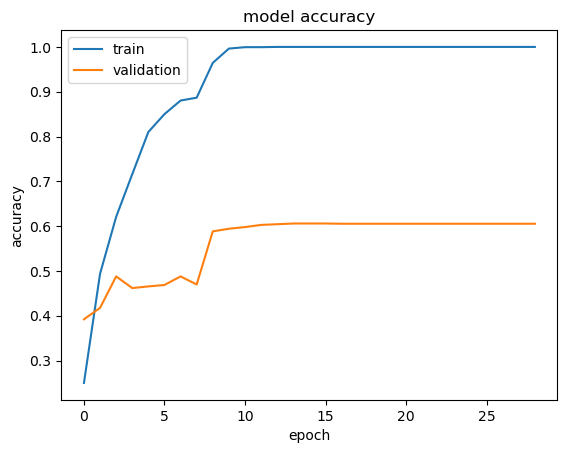

In [8]:
# Plot the training and validation accuracy
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [9]:
import tensorflow as tf
model = tf.keras.models.load_model(f"{dataset}/{model_name}")

In [10]:
model.evaluate(test_data)

118/118 [==============================] - 57s 438ms/step - loss: 1.7107 - accuracy: 0.6223


[1.7107197046279907, 0.6223404407501221]

In [12]:
# Calculate inference time on test data 
import time

start = time.time()
model.predict(test_data)
end = time.time()
print(f"Time taken: {end-start} seconds")
print(f"Time taken per image: {(end-start)/len(data[2])} seconds")


  1/118 [..............................] - ETA: 1:02

118/118 [==============================] - 51s 434ms/step
Time taken: 51.31120300292969 seconds
Time taken per image: 0.027293193086664728 seconds


1/1 [==============================] - 0s 40ms/step


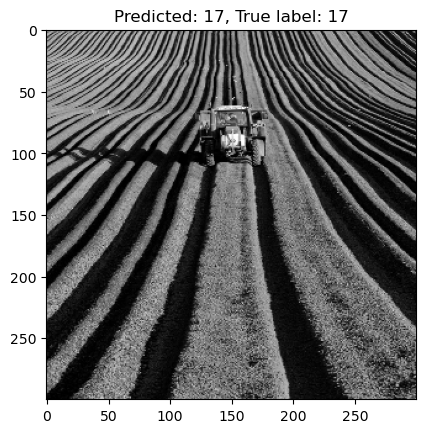

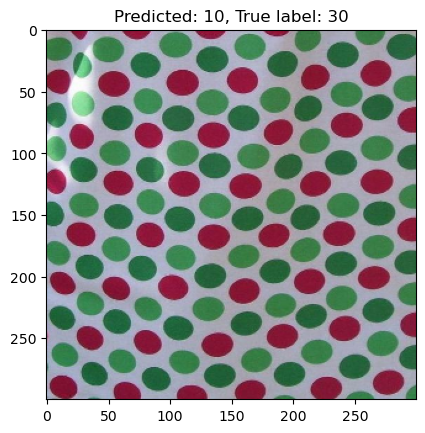

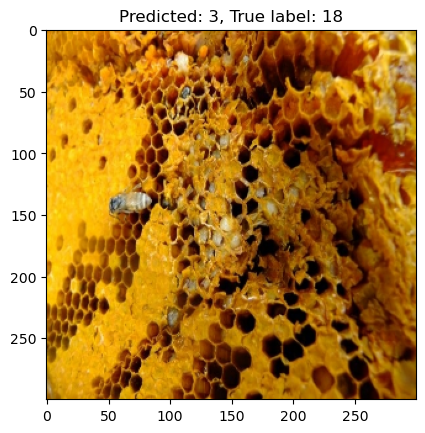

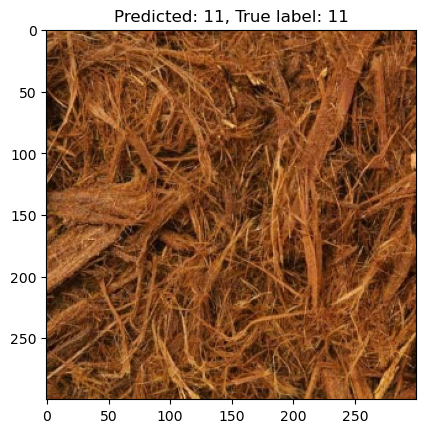

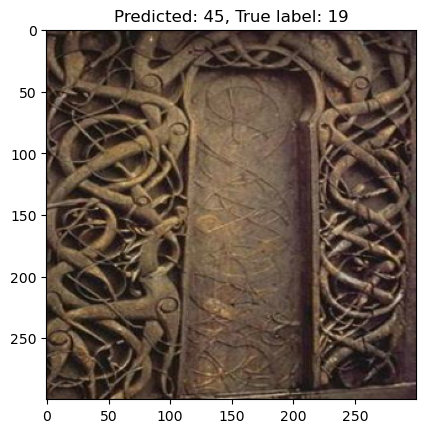

In [20]:
# Plot the validation data with the predicted labels
import numpy as np
import matplotlib.pyplot as plt
for i in val_data.shuffle(100).take(1):
    image = i[0]
    label = i[1]
    break
predictions = model.predict(image)
for i in range(5):
    plot_image = (image[i]).numpy().astype(np.float32)
    plt.imshow(plot_image)
    plt.title(f'Predicted: {np.argmax(predictions[i])}, True label: {np.argmax(label[i])}')
    plt.show()
    

1/1 [==============================] - 0s 36ms/step


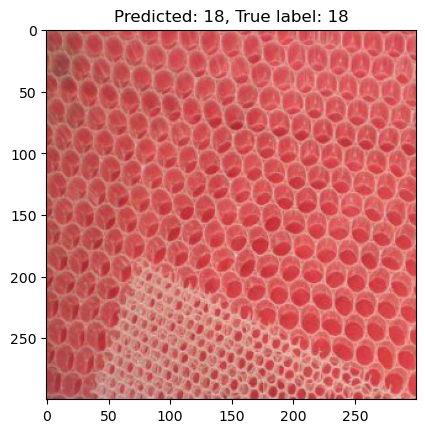

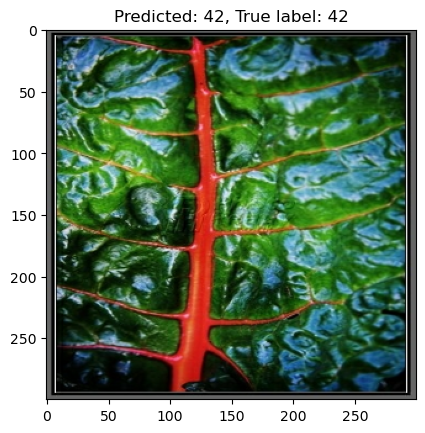

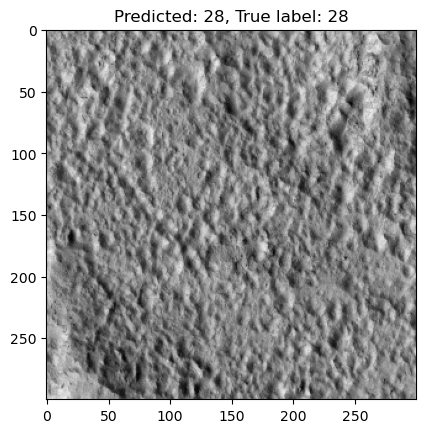

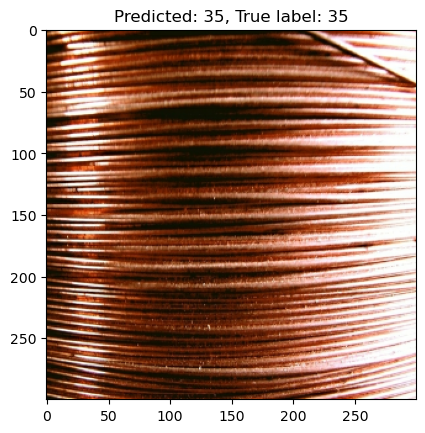

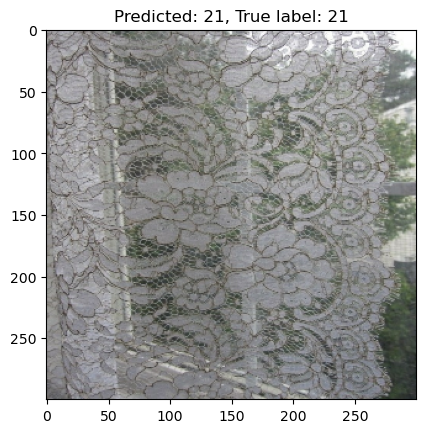

In [18]:
# Plot the validation data with the predicted labels
import numpy as np
import matplotlib.pyplot as plt
for i in train_data.shuffle(100).take(1):
    image = i[0]
    label = i[1]
    break
predictions = model.predict(image)
for i in range(5):
    plot_image = (image[i]).numpy().astype(np.float32)
    plt.imshow(plot_image)
    plt.title(f'Predicted: {np.argmax(predictions[i])}, True label: {np.argmax(label[i])}')
    plt.show()
    